# Homework 3 - Principal Component Analysis on Neuron Spike Sorting
You should have downloaded:
- spikes.csv

The homework performs PCA, but in a setting that will feel less familiar from simpler examples seen in lecture or section. But the underlying mathematics in identical and you will get a chance to see a more "real-life" application of PCA.

# 0 Introduction

A large amount of research in neuroscience is based on the study of the activity of neurons recorded extracellularly with microwires (very thin electrodes) implanted in animals’ brains. These microwires ‘listen’ to **a few neurons close-by** the electrode tip that fire action potentials or ‘spikes’. **Each neuron has spikes of a characteristic shape**, which is determined by a variety of factors.

Spike sorting seeks to **group spikes into clusters** based on the similarity of their shapes. Each cluster of spikes will correspond to individual neurons. Thus, we can understand neuron activity better if we can study their activity from the spikes in the data.

We will process sample neuronal voltage recordings and use Principal Component Analysis (PCA) to separate spikes.

Reference: http://www.scholarpedia.org/article/Spike_sorting

This data has been preprocesed and centered for each spike to coincide with the others. 
- There are 3298 spikes.
- Each spike contains 70 recordings representing 70 $ms$ of data. So, there are 70 features per datum.

# 1 Load and visualize data
**Task:**
1. [1 pt] Load two dimensional array `X` in which:
    - rows are the 70 voltage readings for each spike (number of features)
    - columns are observed spikes (number of data)

2. [2 pt] Display the first 30 spikes in one figure.
    - the horizontal axis would be the 70 recordings, in $ms$.
    - the vertical axis would be the voltage, in $mV$.
    - Include axis labels and a title

(70, 3298)


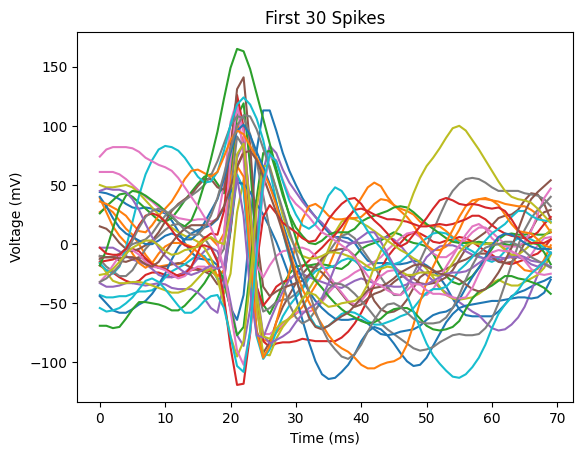

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# TODO load
df = pd.read_csv('spikes.csv', header=None)
X = df.values
print(X.shape)

# TODO plot
for i in range(30):
    plt.plot(X[:, i])

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('First 30 Spikes')
plt.show()

# 2 PCA

We are interested in correlating ''spikes in the waveform'' to ''the activity of neurons''. 

The difficulty arrises from the fact that observed spikes can arise from the different neurons that are firing in the neighborhood of microwire (detector). Interactions (''correlation'') between spikes from different neuronal population can siginificantly change the voltage recording shape. For example, the peak of action potential from neuronal acticivity from one cell can be reduced if it concides with the dip of action potential from another cell firing. 

Historically, PCA has been proposed as a method to seperate spikes into clusters of neuronal activity. Let's try it ourselves.

## 2.1 Eigendecomposition by sklearn
**Task:** 
1. [1 pt] Center data by subtracting the mean, store it as ```X_ctd```. 
2. [4 pt] Use the sklearn PCA package to:
    - fit data
    - find covariance matrix, store it as ```cov_mat```
    - find eigenvalues/singular values, store it as ```evals``` (Rmk: singular_values_ is not singular values, Go figure. -.-)
    - find principal components, store it as ```evecs```. Your columns should be the eigenvectors. (Rmk: package gives tranposed version, i.e., rows are the principal components, not columns.)

Through this exercise, we should gain familiarity with the package and understand that you MUST read documentation before using packages.

In [48]:
# TODO sklearn pca
from sklearn.decomposition import PCA
import numpy as np

X_ctd = X - X.mean(axis=1)[:, np.newaxis]

pca = PCA()
pca.fit(X_ctd)

cov_mat = pca.get_covariance()
evals = pca.explained_variance_
evecs = pca.components_.T

# 2.2 Scree plot
1. [1 pt] What is a "scree"? What does it mean? This is not a math question. Google it and spend 10 minutes of fun on the web.

    **Ans:** A scree plot is a plot where the y-axis is the eigenvalues, sorted from high to low, and the x-axis is the component number. So at the beginning components, the eigenvalues are high since these are components that can explain more of the variance, but they diminish rapidly unti basically flattening since most of the variation can be explained with just the top few components.
2. [2 pt] Make a scree plot of the eigenvalues of the covariance matrix.
    - Include title and axis labels

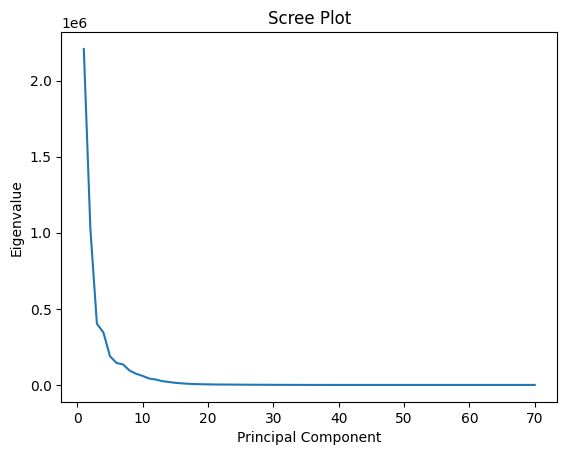

In [49]:
# TODO plot
evals_sorted = np.sort(evals)[::-1]

plt.plot(range(1, len(evals_sorted) + 1), evals_sorted)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

# 3 Eigenbasis
## 3.1 Visualization of principal components
1. [2 pt] Generate a 2D plot to display the first 4 principal components.
- Each PC is basically a spike signal, like those plotted earlier. This is how we will visualize a 70-dimensional vector in a two dimensional plot.
- Include a title, legend, and axis labels.

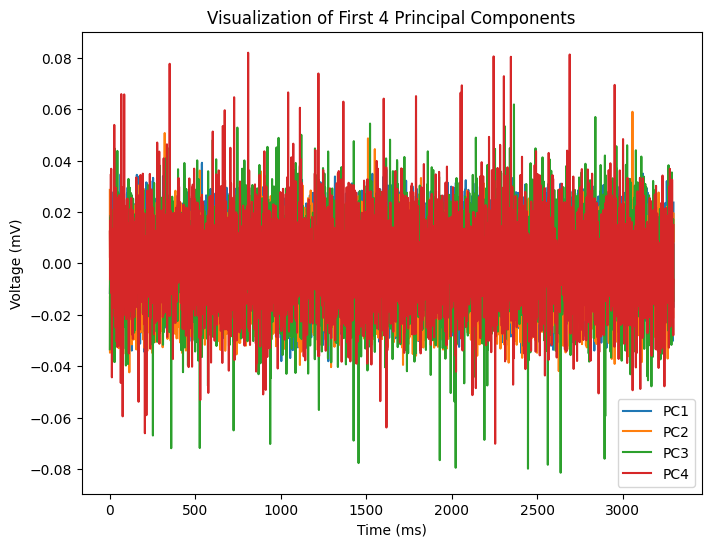

In [50]:
# TODO plot PCs
fig, ax = plt.subplots(figsize=(8, 6)) 

for i in range(4):
    ax.plot(evecs[:, i])

# Labels and legend
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Visualization of First 4 Principal Components')
ax.legend([f'PC{i+1}' for i in range(4)])

plt.show()

2. [1 pt] Write code to verify that the first 4 principal components are indeed orthogonal.

In [51]:
# TODO verify
for i in range(4):
        for j in range(i + 1, 4):  
            dot_product = np.dot(evecs[:, i], evecs[:, j])
            print(f"Dot Product of PC{i+1} and PC{j+1}: {dot_product}")
            print(f"Orthogonal? {np.isclose(dot_product, 0)}")

Dot Product of PC1 and PC2: -5.366800753803247e-17
Orthogonal? True
Dot Product of PC1 and PC3: 9.974659986866641e-17
Orthogonal? True
Dot Product of PC1 and PC4: -1.6544925152128798e-16
Orthogonal? True
Dot Product of PC2 and PC3: 2.2551405187698492e-17
Orthogonal? True
Dot Product of PC2 and PC4: -2.389581588158052e-16
Orthogonal? True
Dot Product of PC3 and PC4: 1.1449174941446927e-16
Orthogonal? True


## 3.2 Signal reconstruction without sklearn
Because the principal components form an basis, each spike can be reconstructed using some weighted sum of the principal components. In this subsection, do not use sklearn package.

**How to reconstruct?** For example, if we are reconstructing the spike with the first $k$ PC, you will project the spike to these principal components with 
$$U_{1:k} U_{1:k}^TX$$
where $U_{1:k}$ is the matrix with first $k$ PCs on each column and $X$ is the spike (column vector).

**Task:**

In the same figure,
1. [1 pt] Plot the first spike, ```spike01```, by indexing the correct row/column of `X_ctd`. 
    - Use solid line to differentiate it more easily from the next plots below.
2. [2 pt] Reconstruct an approximation to ```spike01``` using the first prinicpal component only. 
    - Remember, we are using only one component, so the reconstruction will not be precise, it is only approximate. Use dashed lines to differentiate it from the true ```spike01```.
3. [1 pt] Then repeat the reconstruction of ```spike01``` using the first two, first three, first four, and finally all principal components. Might help to use a for-loop.

4. [1 pt] Your plots should include title, legend, axis labels.

At the end, you should have 6 plots in the same figure:
1. original spike
2. Approximate reconstruction with 1 PC
3. Approximate reconstruction with 2 PC
4. Approximate reconstruction with 3 PC
5. Approximate reconstruction with 4 PC
6. Approximate reconstruction with 70 PC

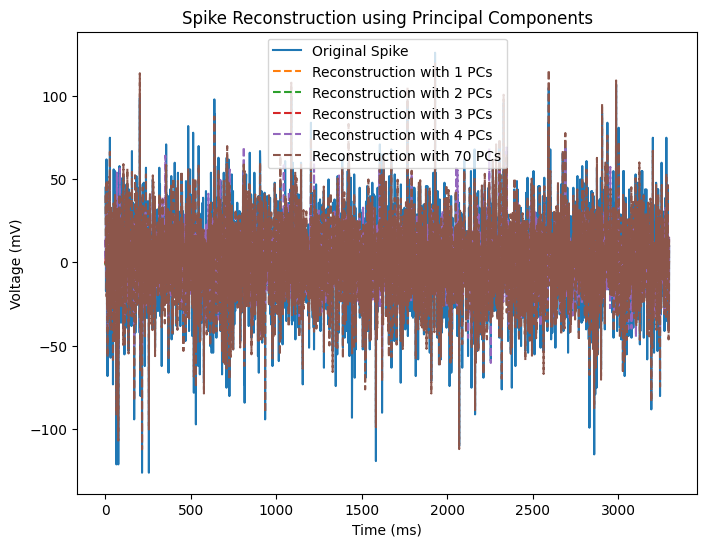

In [52]:
# TODO plot

spike01 = X_ctd[0, :] 

num_components_to_test = [1, 2, 3, 4, 70] 

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(spike01, linestyle='-', label='Original Spike')

for k in num_components_to_test:
    U = evecs[:, :k]
    projection = U @ U.T @ spike01 
    ax.plot(projection, linestyle='--', label=f'Reconstruction with {k} PCs')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Spike Reconstruction using Principal Components')
ax.legend()

plt.show()


In [53]:
"""
fig, axes = plt.subplots(len(num_components_to_test), 1, figsize=(8, 12)) 

for ax in axes:
    ax.plot(spike01, label='Original Spike', color='red')  


for i, k in enumerate(num_components_to_test):
    U = evecs[:, :k]
    projection = U @ U.T @ spike01 
    axes[i].plot(projection, label=f'Reconstruction with {k} PCs')
    axes[i].set_title(f'Reconstruction with {k} Principal Components')

fig.supxlabel('Time (ms)') 
fig.supylabel('Voltage (mV)')
fig.suptitle('Spike Reconstructions Compared to Original') 

plt.tight_layout() 
plt.show()
"""


"\nfig, axes = plt.subplots(len(num_components_to_test), 1, figsize=(8, 12)) \n\nfor ax in axes:\n    ax.plot(spike01, label='Original Spike', color='red')  \n\n\nfor i, k in enumerate(num_components_to_test):\n    U = evecs[:, :k]\n    projection = U @ U.T @ spike01 \n    axes[i].plot(projection, label=f'Reconstruction with {k} PCs')\n    axes[i].set_title(f'Reconstruction with {k} Principal Components')\n\nfig.supxlabel('Time (ms)') \nfig.supylabel('Voltage (mV)')\nfig.suptitle('Spike Reconstructions Compared to Original') \n\nplt.tight_layout() \nplt.show()\n"

## 3.3 Data projection with sklearn

**Task:**
1. [1 pt] Project the centered data ```X_ctd``` onto the principal components using an appropriate method in the sklearn PCA pacakage, store it is ```X_proj```.
    - X_proj should have dimensions 70 by 3298. You may need to take transposes accordingly.
2. [2 pt] What is the interpretation of `X_proj[0,:]`? What does each entry represent? Similarly, what is the interpretation of `X_proj[i,:]` for arbitrary row i?

    **Ans:** For an arbitrary row i, the ith row of X_proj represents the scores of each spike along the i-th principal component

In [54]:
# TODO project

X_proj = pca.fit_transform(X_ctd.T).T
print(X_proj.shape)


(70, 3298)


# 4 Dimensionality reduction
## 4.1 Histogram
[2 pt] On separate figures:
- plot a histogram of `X_proj[0,:]`
- plot a histogram of `X_proj[1,:]`

Set:
- 50 bins equispaced between [-550,550]

So, each histogram uses 3298 datapoints.

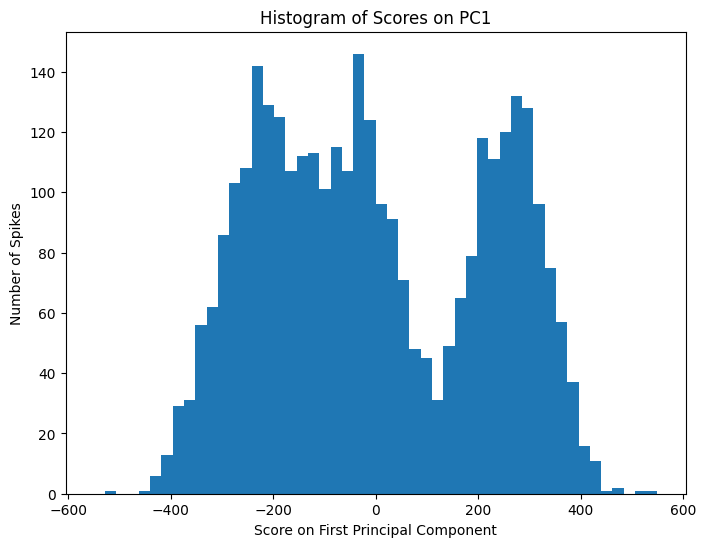

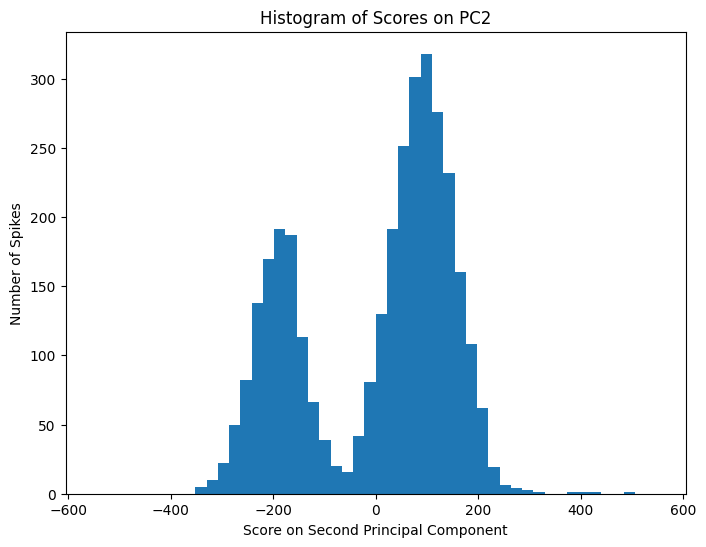

In [55]:
# TODO show a histogram of the first principal component

plt.figure(figsize=(8, 6))
plt.hist(X_proj[0, :], bins=50, range=(-550, 550))
plt.xlabel('Score on First Principal Component')
plt.ylabel('Number of Spikes')
plt.title('Histogram of Scores on PC1')

# TODO show a histogram of the second principal component 
plt.figure(figsize=(8, 6))
plt.hist(X_proj[1, :], bins=50, range=(-550, 550))
plt.xlabel('Score on Second Principal Component')
plt.ylabel('Number of Spikes')
plt.title('Histogram of Scores on PC2')

plt.show()


## 4.2 Visualize data with PC1 and PC2
1. [2 pt] Create scatter plot of the data projected onto the first two principal components.
    - y axis: PC2
    - x axis: PC1
    - Include title, axis labels

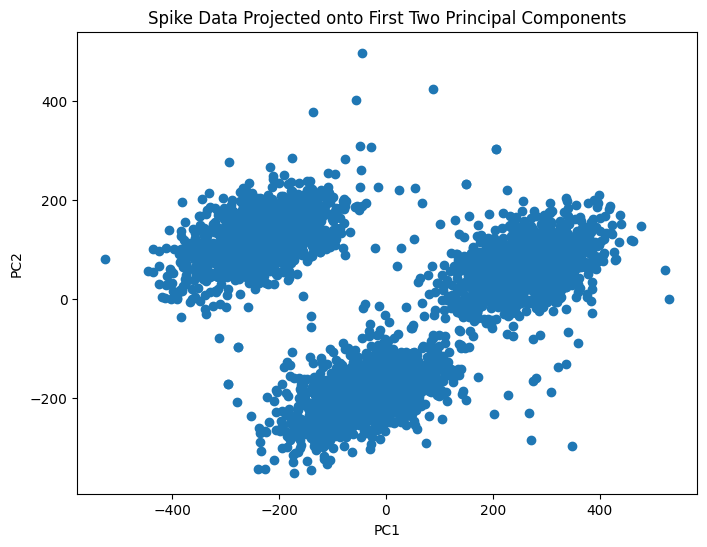

In [56]:
# TODO scatter
plt.figure(figsize=(8, 6))
plt.scatter(X_proj[0, :], X_proj[1, :])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Spike Data Projected onto First Two Principal Components')
plt.show()

2. [1 pt] What does the scatter plot suggest about the number of potential neuronal clusters?

    **Ans:** I see at least three potential neuronal clusters.
    